In [1]:
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import os
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import math
targetXYResolution = 256
def process_image(image_path):
    global target_width, target_height
    # Load image
    img = Image.open(image_path).convert('RGB')

    # Resize image preserving aspect ratio
    img.thumbnail((targetXYResolution, targetXYResolution))

    # Create a new image with black background
    new_img = Image.new('RGB', (targetXYResolution, targetXYResolution))
    width, height = img.size

    # Calculate positioning for centering the image
    left = (targetXYResolution - width) // 2
    top = (targetXYResolution - height) // 2
    new_img.paste(img, (left, top))

    return new_img, new_img

def images_to_tensor(directory, a, b, return_images=False):
    tensor_list = []
    image_list = []  # To store PIL images for visualization
    file_list = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))][a:b]
    for filename in tqdm(file_list, desc="Processing images", unit="images"):
        file_path = os.path.join(directory, filename)
        try:
            processed_img, original_img = process_image(file_path)
            img_tensor = torch.from_numpy(np.array(processed_img))
            # check_image_colors(img_tensor)
            img_tensor = img_tensor.to(torch.float32) / 255 # HxWxC
            img_tensor = img_tensor.transpose(0, 2).transpose(1, 2) # CxWxH, CxHxW
            tensor_list.append(img_tensor)
            if return_images:
                image_list.append(original_img)  # Append original image
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    tensors = torch.stack(tensor_list)
    return (tensors, image_list) if return_images else tensors

Processing images: 100%|██████████| 100/100 [00:00<00:00, 279.34images/s]


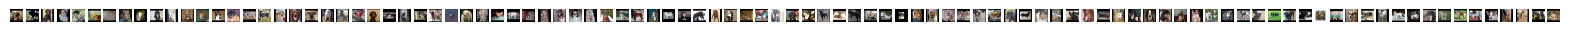

In [2]:
import matplotlib.pyplot as plt

start, finish =2000, 2100
# Load the images and return both tensors and original images for display
data, original_images = images_to_tensor('PetImages/Dog', start, finish, return_images=True)

# Display the images using matplotlib
fig, axes = plt.subplots(1, finish-start, figsize=(20, 4))  # Adjust subplot parameters as needed
for i, img in enumerate(original_images):
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
plt.show()

In [3]:
# Specify the directory containing the images
cats = 'PetImages/Cat'
dogs = 'PetImages/Dog'

# Convert images to a tensor
cats_tensor = images_to_tensor(cats, 0, 500)
dogs_tensor = images_to_tensor(dogs, 0, 500)
cats_tensorVal = images_to_tensor(cats, 12000, 12300)
dogs_tensorVal = images_to_tensor(dogs, 12000, 12300)

print(cats_tensor.shape)  # This should print: torch.Size([N, 3, 500, 500]), N is the number of processed images
print(dogs_tensor.shape)  # This should print: torch.Size([N, 3, 500, 500]), N is the number of processed images

# Labels (0 for cats, 1 for dogs)
cats_labels = torch.zeros(cats_tensor.size(0))
dogs_labels = torch.ones(dogs_tensor.size(0))
cats_labelsVal = torch.zeros(cats_tensorVal.size(0))
dogs_labelsVal = torch.ones(dogs_tensorVal.size(0))

# Combine datasets
features = torch.cat([cats_tensor, dogs_tensor], dim=0)
labels = torch.cat([cats_labels, dogs_labels], dim=0)
featuresVal = torch.cat([cats_tensorVal, dogs_tensorVal], dim=0)
labelsVal = torch.cat([cats_labelsVal, dogs_labelsVal], dim=0)

# Create a dataset and data loader
dataset = TensorDataset(features, labels) # the first dimension is the data index
datasetVal = TensorDataset(featuresVal, labelsVal)
#delete cats and dogs tensor here
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)
data_loaderVal = DataLoader(datasetVal, batch_size=10)
del cats_tensor
del dogs_tensor
del features
del labels
del cats_tensorVal
del dogs_tensorVal
del featuresVal
del labelsVal

Processing images: 100%|██████████| 300/300 [00:01<00:00, 298.94images/s]


torch.Size([500, 3, 256, 256])
torch.Size([500, 3, 256, 256])


In [4]:
from vit_pytorch import ViT

# Initialize and load the model
model = ViT(
    image_size = targetXYResolution,
    patch_size = 32,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)

In [5]:
# Training loop
epochs = 15

for epoch in range(epochs):
    model.train()
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).long()  # CrossEntropyLoss expects targets as long (integer) type
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)  # Use raw logits from the model
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    model.eval()
    n_correct = 0.
    n_total = 0.
    for inputs, targets in data_loaderVal:
        inputs = inputs.to(device)
        targets = targets.to(device).long()
        outputs = model(inputs)
        _, prediction = torch.max(outputs, dim=1)
        n_correct += (prediction == targets).sum().item()
        n_total += targets.size(0)
    print(f'Epoch {epoch+1}, Val Accuracy: {n_correct / n_total}')

# Save the model if needed
torch.save(model.state_dict(), 'simple_transformer_model.pth')

Epoch 1, Loss: 0.7091341018676758
Epoch 1, Val Accuracy: 0.5716666666666667
Epoch 2, Loss: 0.6838916540145874
Epoch 2, Val Accuracy: 0.5916666666666667
Epoch 3, Loss: 0.5026950240135193
Epoch 3, Val Accuracy: 0.6016666666666667
Epoch 4, Loss: 0.6825690269470215
Epoch 4, Val Accuracy: 0.64
Epoch 5, Loss: 0.4041934013366699
Epoch 5, Val Accuracy: 0.6
Epoch 6, Loss: 0.5355063676834106
Epoch 6, Val Accuracy: 0.5966666666666667
Epoch 7, Loss: 0.3636499345302582
Epoch 7, Val Accuracy: 0.5983333333333334
Epoch 8, Loss: 0.1022554263472557
Epoch 8, Val Accuracy: 0.5766666666666667
Epoch 9, Loss: 0.0924510806798935
Epoch 9, Val Accuracy: 0.6016666666666667
Epoch 10, Loss: 0.06181797385215759
Epoch 10, Val Accuracy: 0.6216666666666667
Epoch 11, Loss: 0.008097131736576557
Epoch 11, Val Accuracy: 0.6083333333333333
Epoch 12, Loss: 0.00301584554836154
Epoch 12, Val Accuracy: 0.6033333333333334
Epoch 13, Loss: 0.017650838941335678
Epoch 13, Val Accuracy: 0.6033333333333334
Epoch 14, Loss: 0.144830241

In [6]:
# Initialize and load the model
model = ViT(
    image_size = targetXYResolution,
    patch_size = 32,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)
# model.load_state_dict(torch.load('simple_transformer_model.pth'))
data = data.to(device)
model.eval()

# Calculate and print the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

with torch.inference_mode():
    output = model(data)
    _, prediction = torch.max(output, dim=1) # batch, prediction
    print(prediction)

Total number of parameters: 53607426
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
